### Import Libraries

In [1]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import importlib
import os

import utils

### Baseline models:

* **Fixed-Prob:** Presuming that each home team will win 52% of the time. We assign the home visitor as winner at random with a probability of 0.52.
* **Scored-Runs-Prob:** Compute the accumulated probability of each team to win. This baseline considers the number of runs made by each team before the current game.
* **Runs-Ratio:** Looking at the ratio of runs scored over runs allowed and whichever team has the highest ratio is the predicted winner

### Machine Learning-based model:

The set of features we compute are:

* Historical number of runs scored by the home/visitor team.
* Historical number of runs allowed by the home/visitor team.
* Number of games played by each team.
* Rate of games won by each team.
* Bag-of-words of players that participated in the game
* Historical statistics of each type of batting result (e.g. Pop Out, Walk, Strikeout) by each team.

We train a logistic regression model using those features. We choose the best regularization strength using nested K-fold cross-validation.

In [4]:
utils = importlib.reload(utils)

path = os.path.join('data', 'baseball_atbats')

def evaluate_year(path, year):
    # Load the dataset
    X, y, Xpreproc = utils.load_dataset(path, year)

    # Extend the dataset with the new features per game
    Xpreproc = utils.preprocess_dataset(X, Xpreproc)

    # Get the names of the features related to the batting outcomes
    descr_features = [f for f in Xpreproc.columns if f.startswith('descr')]

    # Split the dataset in train/test
    trN = int(0.8 * Xpreproc.shape[0])

    trX = Xpreproc.iloc[: trN]
    tsX = Xpreproc.iloc[trN:]

    y_ = y > 0
    trY = y_[: trN]
    tsY = y_[trN:]
    
    # Set of base predictive features
    features = ['home-prob', 'home-pos-runs', 'home-neg-runs', 'visitor-pos-runs', 'visitor-neg-runs',
                'home-games-played', 'visitor-games-played', 'home-win', 'visitor-win',
                'home-ratio-prob',
                ]

    # Players involved in the game using a one-hot encoding
    pitcher_onehot = CountVectorizer(binary=True).fit(trX.pitchers.values)
    pitcher_tr = pitcher_onehot.transform(trX.pitchers.values).todense()
    pitcher_ts = pitcher_onehot.transform(tsX.pitchers.values).todense()

    batter_onehot = CountVectorizer(binary=True).fit(trX.batters.values)
    batter_tr = batter_onehot.transform(trX.batters.values).todense()
    batter_ts = batter_onehot.transform(tsX.batters.values).todense()

    model = LogisticRegressionCV(n_jobs=-1, cv=5)
    
    # Base features
    tr_ft = trX[features].as_matrix()
    ts_ft = tsX[features].as_matrix()
    clf = make_pipeline(Imputer(), model).fit(tr_ft, trY)
    preds1 = clf.predict_proba(ts_ft)[:, 1]

    # Base features + players
    tr_ft = np.hstack((tr_ft, pitcher_tr, batter_tr))
    ts_ft = np.hstack((ts_ft, pitcher_ts, batter_ts))
    clf = make_pipeline(Imputer(), model).fit(tr_ft, trY)
    preds2 = clf.predict_proba(ts_ft)[:, 1]

    # Base features + players + descr
    tr_ft = np.hstack((tr_ft, trX[descr_features].as_matrix()))
    ts_ft = np.hstack((ts_ft, tsX[descr_features].as_matrix()))
    clf = make_pipeline(Imputer(), model).fit(tr_ft, trY)
    preds3 = clf.predict_proba(ts_ft)[:, 1]
    
    all_preds = [('Fixed-Prob', tsX['home-52'].values),
                 ('Scored-Runs-Prob', tsX['home-prob'].values),
                 ('Runs-Ratio', tsX['home-ratio-prob'].values),
                 ('Model-base', preds1),
                 ('Model-base+players', preds2),
                 ('Model-base+players+descr', preds3),             
                ]

    # Commpute the performance of each model
    results = [(k,
                metrics.brier_score_loss(tsY, preds),
                metrics.roc_auc_score(tsY, preds),
                metrics.average_precision_score(tsY, preds),
                metrics.accuracy_score(tsY, preds > 0.5))
                for k, preds in all_preds]

    df_res = pd.DataFrame(results, columns=['Model', 'Brier', 'ROC-AUC', 'PR-AUC', 'Accuracy'])
    
    # Plot the ROC curves
    plt.figure(figsize=(10, 10))
    for method, preds in all_preds:
        fpr, tpr, _ = metrics.roc_curve(tsY, preds)

        plt.plot(fpr, tpr, label=method)
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.legend(loc='best')
    plt.show()

    return df_res, all_preds, tsY

### Model Performance

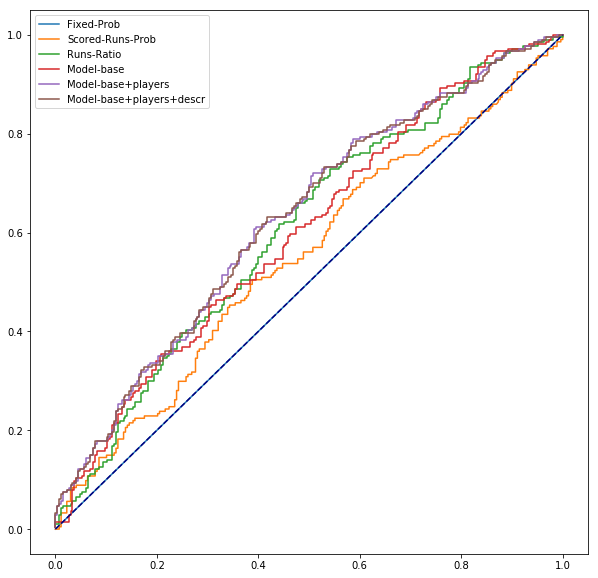

,Model,Brier,ROC-AUC,PR-AUC,Accuracy
0,Fixed-Prob,0.252641,0.500000,0.443983,0.443983
1,Scored-Runs-Prob,0.247954,0.549562,0.495477,0.545643
2,Runs-Ratio,0.243023,0.605890,0.533125,0.576763
3,Model-base,0.242772,0.600572,0.533458,0.556017
4,Model-base+players,0.240308,0.628348,0.575085,0.601660
5,Model-base+players+descr,0.240698,0.626778,0.575959,0.601660


In [20]:
preds_per_model = {}
all_y = []

df, next_preds, next_y = evaluate_year(path, 2012)
preds_per_model = {m: preds_per_model.get(m, []) + list(preds)
                   for m, preds in next_preds}
all_y += list(next_y)
df

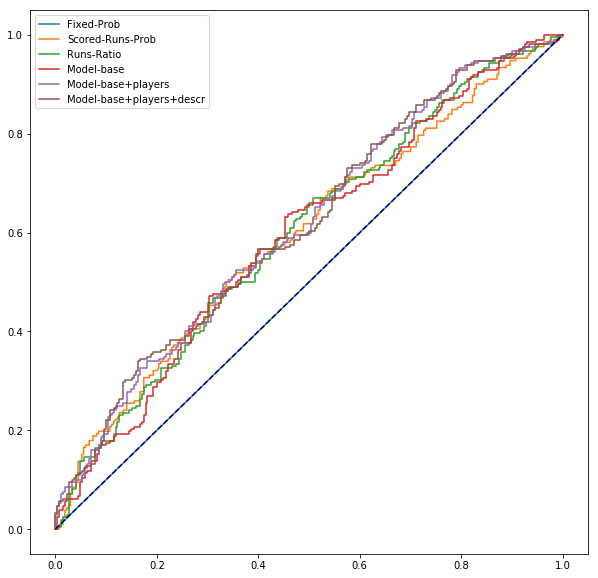

,Model,Brier,ROC-AUC,PR-AUC,Accuracy
0,Fixed-Prob,0.252807,0.500000,0.439834,0.439834
1,Scored-Runs-Prob,0.245803,0.594410,0.531654,0.566390
2,Runs-Ratio,0.243808,0.597449,0.526065,0.570539
3,Model-base,0.240260,0.593728,0.525984,0.576763
4,Model-base+players,0.255887,0.611880,0.562941,0.587137
5,Model-base+players+descr,0.255299,0.613277,0.564846,0.578838


In [21]:
df, next_preds, next_y = evaluate_year(path, 2013)
preds_per_model = {m: preds_per_model.get(m, []) + list(preds)
                   for m, preds in next_preds}
all_y += list(next_y)
df

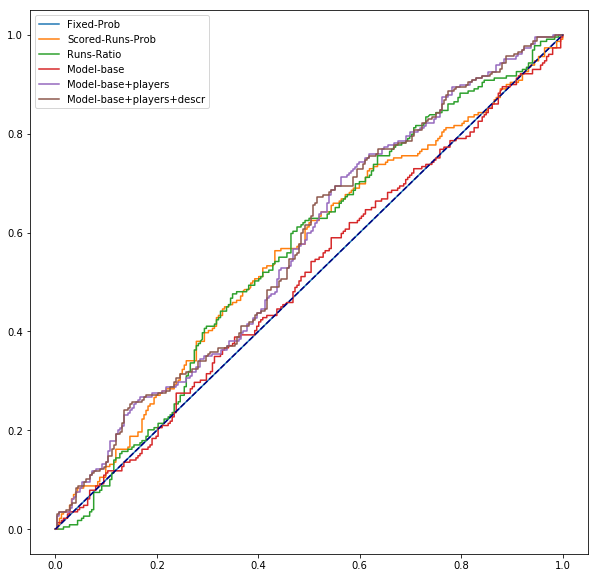

,Model,Brier,ROC-AUC,PR-AUC,Accuracy
0,Fixed-Prob,0.251356,0.500000,0.476091,0.476091
1,Scored-Runs-Prob,0.248198,0.557505,0.527546,0.553015
2,Runs-Ratio,0.248182,0.561187,0.499564,0.559252
3,Model-base,0.256381,0.507070,0.484488,0.519751
4,Model-base+players,0.250251,0.571290,0.539224,0.534304
5,Model-base+players+descr,0.250210,0.572087,0.540168,0.528067


In [22]:
df, next_preds, next_y = evaluate_year(path, 2014)
preds_per_model = {m: preds_per_model.get(m, []) + list(preds)
                   for m, preds in next_preds}
all_y += list(next_y)
df

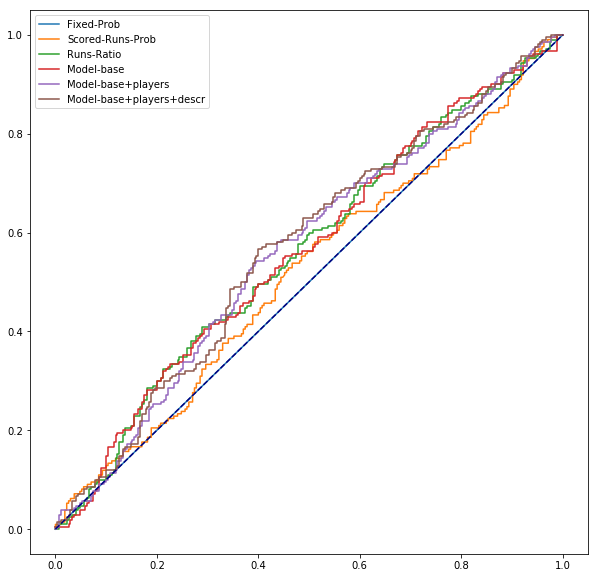

,Model,Brier,ROC-AUC,PR-AUC,Accuracy
0,Fixed-Prob,0.252900,0.500000,0.437500,0.437500
1,Scored-Runs-Prob,0.249405,0.517522,0.466435,0.533333
2,Runs-Ratio,0.247584,0.559277,0.478408,0.539583
3,Model-base,0.247870,0.560194,0.480172,0.552083
4,Model-base+players,0.283731,0.562257,0.483726,0.566667
5,Model-base+players+descr,0.280814,0.567407,0.489984,0.560417


In [23]:
df, next_preds, next_y = evaluate_year(path, 2015)
preds_per_model = {m: preds_per_model.get(m, []) + list(preds)
                   for m, preds in next_preds}
all_y += list(next_y)
df

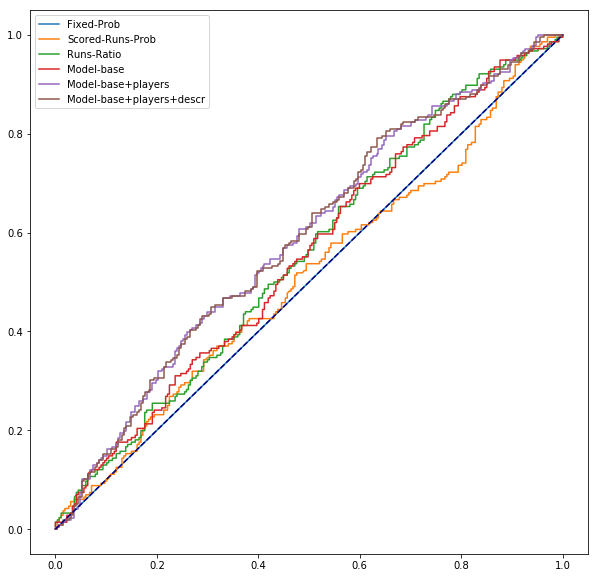

,Model,Brier,ROC-AUC,PR-AUC,Accuracy
0,Fixed-Prob,0.252512,0.500000,0.447205,0.447205
1,Scored-Runs-Prob,0.249794,0.509398,0.469294,0.513458
2,Runs-Ratio,0.247613,0.552911,0.497399,0.532091
3,Model-base,0.246275,0.551195,0.494039,0.534161
4,Model-base+players,0.272134,0.587980,0.512273,0.563147
5,Model-base+players+descr,0.270026,0.587859,0.512588,0.559006


In [24]:
df, next_preds, next_y = evaluate_year(path, 2016)
preds_per_model = {m: preds_per_model.get(m, []) + list(preds)
                   for m, preds in next_preds}
all_y += list(next_y)
df

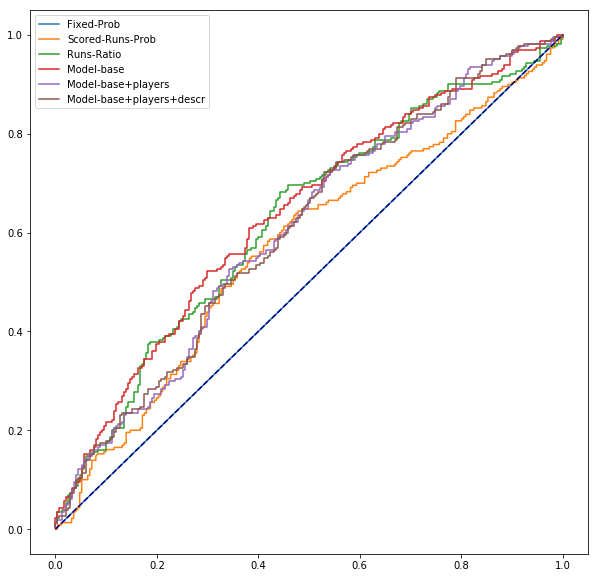

,Model,Brier,ROC-AUC,PR-AUC,Accuracy
0,Fixed-Prob,0.251273,0.500000,0.478170,0.478170
1,Scored-Runs-Prob,0.247395,0.571315,0.534995,0.573805
2,Runs-Ratio,0.241169,0.623818,0.595875,0.598753
3,Model-base,0.240865,0.636151,0.610980,0.567568
4,Model-base+players,0.256011,0.605838,0.575033,0.584200
5,Model-base+players+descr,0.256514,0.606236,0.574282,0.575884


In [25]:
df, next_preds, next_y = evaluate_year(path, 2017)
preds_per_model = {m: preds_per_model.get(m, []) + list(preds)
                   for m, preds in next_preds}
all_y += list(next_y)
df

## Final Results

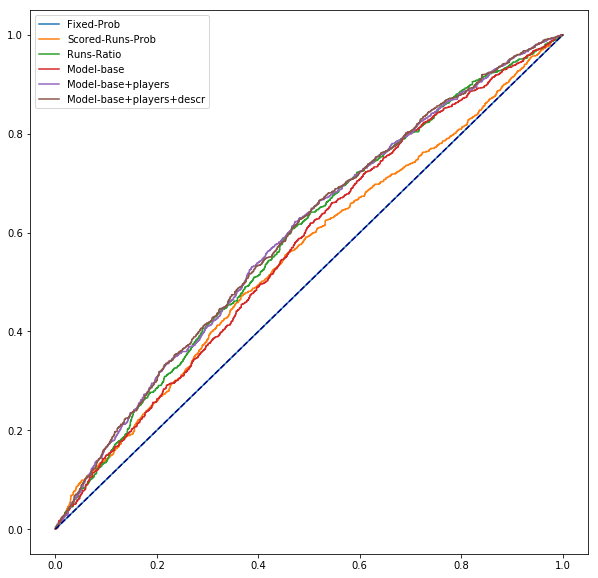

,Model,Brier,ROC-AUC,PR-AUC,Accuracy
0,Fixed-Prob,0.252248,0.500000,0.453790,0.453790
1,Scored-Runs-Prob,0.248091,0.552591,0.505833,0.547594
2,Runs-Ratio,0.245229,0.584253,0.520360,0.562825
3,Model-base,0.245734,0.568720,0.507184,0.551056
4,Model-base+players,0.259713,0.591878,0.527463,0.572863
5,Model-base+players+descr,0.258919,0.593254,0.530304,0.567324


In [26]:
results = [(k,
            metrics.brier_score_loss(all_y, preds),
            metrics.roc_auc_score(all_y, preds),
            metrics.average_precision_score(all_y, preds),
            metrics.accuracy_score(all_y, np.asarray(preds) > 0.5))
            for k, preds in preds_per_model.items()]

df_res = pd.DataFrame(results, columns=['Model', 'Brier', 'ROC-AUC', 'PR-AUC', 'Accuracy'])

# Plot the ROC curves
plt.figure(figsize=(10, 10))
for method, preds in preds_per_model.items():
    fpr, tpr, _ = metrics.roc_curve(all_y, preds)

    plt.plot(fpr, tpr, label=method)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc='best')
plt.show()

df_res